# Sta 663


In [2]:
import scipy.stats as stats
import random
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("notebook", font_scale=1.5)

/Users/Jake/anaconda/envs/snakes/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [29]:
np.random.seed(147)

** Leapfrog **

This code is based on the fact that kinetic energy is $K(p) = \sum_{i=1}^n p_i^2$, i,e. all $m_i$=1

In [24]:
def leapfrog(U, grad_U, current_q, Sigma, stepsize=0.25, steps=25):
    '''
    Performs the leapfrog algorithm for HMC, with 1 accept/reject step
    '''
    
    q = current_q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    current_p = p
    q_list=q
    p_list=p
    
    # Half step for momentum at the beginning
    p = p - stepsize*grad_U(q,Sigma)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,Sigma)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,Sigma)/2
    p_list = np.vstack((p_list,p))
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q,Sigma)
    current_K = sum(current_p**2)/2
    proposed_U = U(q,Sigma)
    proposed_K = sum(p**2)/2

    # Accept or reject the state at end of trajectory, returning either the postion at the end
    # of the trajectory or the initial position
    if (np.random.uniform(0,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return(q,p_list,q_list) # Accept
    else:
        return(current_q,p_list,q_list) # Reject
    

**Potential energy and gradient**

In [25]:
def U(q,Sigma):
    '''
    Returns -log p(q)
    '''
    return (-np.log(stats.multivariate_normal.pdf(q, mean=np.zeros(q.size), cov = Sigma)))

def grad_U(q,Sigma):
    '''
    The partial of U(q) with respect to U.
    In our case, U(q) = q^T(Sigma^{-1})q/2, so the partial is q^T(Sigma^{-1})
    '''
    
    return(np.dot(q,la.inv(Sigma)))

**Running the function**

In [30]:
current_q = np.array([-1.5,-1.55])
Sigma2 = np.array([[1, 0.95],[0.95,1]]) #Correlations of .95 between the two variables
q,p_list,q_list=leapfrog(U, grad_U, current_q, Sigma = Sigma2, stepsize=0.25, steps=25)

**Corresponding HMC values**

In [31]:
Hamiltonian_value = np.zeros(26)
for i in range(26):
    Hamiltonian_value[i] = U(q_list[i,:],Sigma2)+ np.dot(p_list[i,:].T,p_list[i,:])/2

**Illustration of HMC paths**

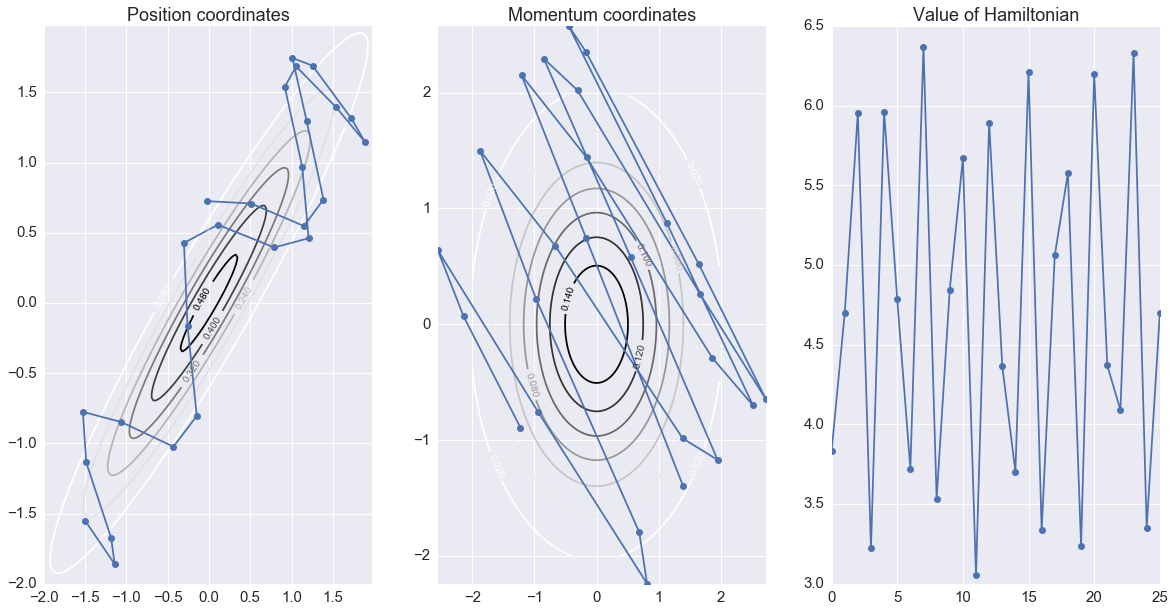

In [32]:
#Setting up the grid to plot over
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(20,10))

#Ploting the position coordinates for the 25 leapfrog steps
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates')
plt.plot(q_list[:,0], q_list[:,1], '-o')

#Plotting the momentum coordinates for the 25 leapfrog steps
plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Momentum coordinates')
plt.plot(p_list[:,0], p_list[:,1], '-o')

#Plotting the Hamiltonian
plt.subplot(133)
plt.plot(np.arange(Hamiltonian_value.size), Hamiltonian_value, '-o')
plt.title('Value of Hamiltonian')
plt.savefig("HMC_eg.png")

**Critical stepsize**


At a critical stepsize the trajectory becomes unstable and the value of Hamiltonian grows without bound. Here we can see the critical stepsize is somewhere close to 0.35

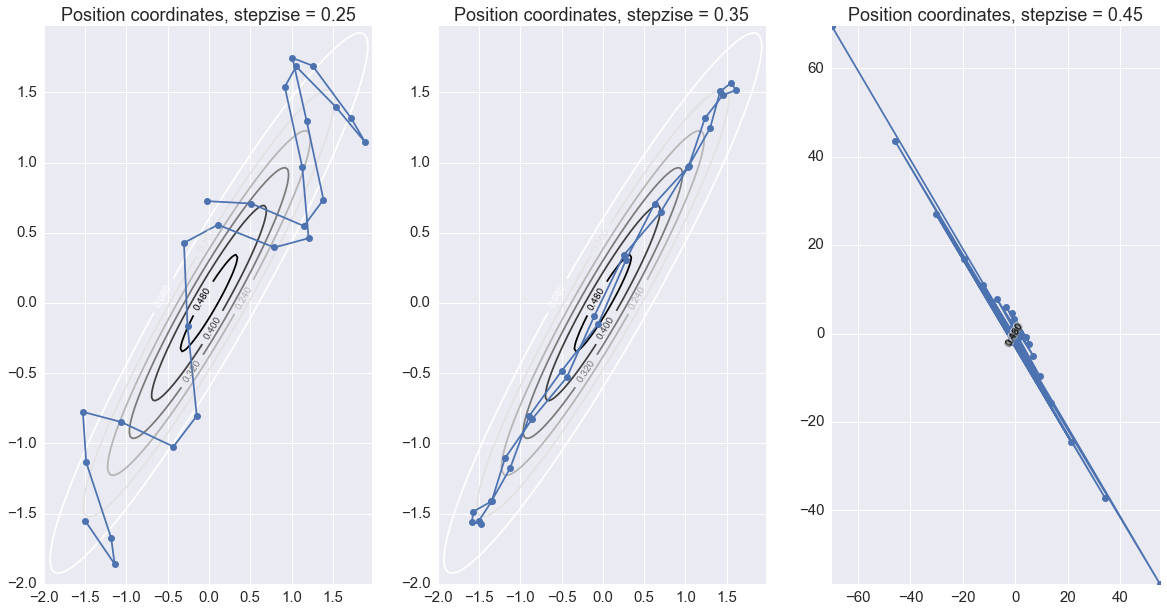

In [33]:
#Getting the leapfrog steps for the larger stepsizes
current_q = np.array([-1.5,-1.55])
q1,p1_list,q1_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.35, steps=25)
current_q = np.array([-1.5,-1.55])
q2,p2_list,q2_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.45, steps=25)

#Plotting 
plt.figure(figsize=(20,10))

#Stepsize of 0.25 as before
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.25')
plt.plot(q_list[:,0], q_list[:,1], '-o')

#Stepsize 0.35 - still traverses the space
plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.35')
plt.plot(q1_list[:,0], q1_list[:,1], '-o')

#Stepsize 0.45 - too large, with clearly unstable position variable
plt.subplot(133)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.45')
plt.plot(q2_list[:,0], q2_list[:,1], '-o')
plt.savefig("HMC_critical_stepsize.png")

# MH vs HMC in 2D

200 iterations of the HMC(with 20 Leapfrog steps per trajectory) for a 2D Gaussian distribution with marginal standard deviations of 1 and correlation 0.98.

**HMC**

In [36]:
def HMC(U, grad_U, current_q, Sigma, stepsize=0.2, steps=25, max_iter= 20, step_range=0):
    '''
    Performs max_iter iterations of HMC with leapfrog discritization method
    To randomize stepsize, set step_range to be nonzero
    '''
    
    current_q_list = current_q
    
    for i in range(max_iter):
        
        #Randomize stepsize if called for
        #Note if step_range = 0, it just draws stepsize
        stepsize_r = np.random.uniform(stepsize-step_range,stepsize+step_range)

        #Keep the position variable after every itertion
        current_q,p_list,q_list = leapfrog(U, grad_U, current_q, Sigma, stepsize_r, steps)
        current_q_list = np.vstack((current_q_list,current_q))
    return(current_q_list[:-1,:])

**Running the HMC**

In [37]:
Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
current_q2 = np.array([-1.5,-1.55])
hmc_output_2d=HMC(U, grad_U, current_q2, Sigma2_high_cor, stepsize=0.18, steps=20, max_iter=200)

**MH**

In [40]:
def metropolis_multigaus(target,proposal,thin,niters,dim):
    '''
    Metropolis algorithm. Flexible for target/proposal distributions, as well as dimensionality
    Thins the chain to avoid autocorrelation
    '''
    post = np.zeros((niters,dim))
    current = proposal.rvs()
    accept = 0
    for i in range(thin*niters):
        #Proposed value
        post_p = current + proposal.rvs() #Assumes proposal.rvs is centered at zero
        
        #Probability of acceptance
        rho = min(1, target.pdf(post_p)/target.pdf(current))
        u = np.random.uniform()
        
        #Accept step
        if u < rho:
            accept += 1
            current = post_p
            
        #Only add to return list if i is a multiple of thin
        if i % thin < 1:
            post[i//thin,:] = current
    return(post,accept/(niters*thin))

**Running the MH**

In [41]:
#Target mean. Note Covariance matrix is alredy defined as Sigma2_high_cor
mu = np.array([0,0])

mu_prop = np.array([0,0])
cov_prop = (np.array([[.18**2,0],[0,.18**2]]))
target2d = stats.multivariate_normal(mu,Sigma2_high_cor)
proposal2d = stats.multivariate_normal(mu_prop,cov_prop)

#Getting the output for metropolis
mh_output_2d, mh_2d_ratio = metropolis_multigaus(target2d,proposal2d,20,200,2)

**Comparing the first 20 iterations of MH vs HMC**

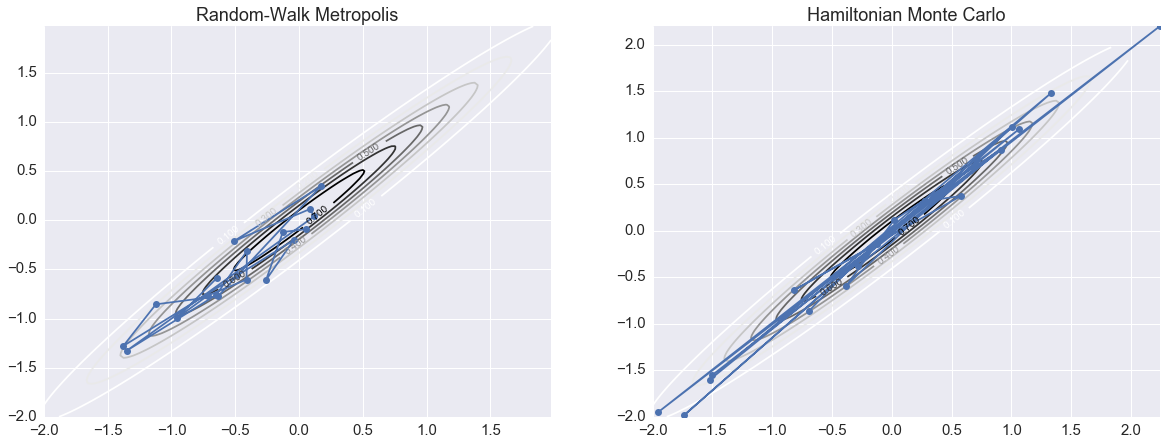

In [42]:
#Setting up the plotting grid
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(20,7))

#Metropolis iterations. Does not cover whole space in this time
plt.subplot(121)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Random-Walk Metropolis')
plt.plot(mh_output_2d[0:19,0],mh_output_2d[0:19,1], '-o')

#HMC iterations. Does a much better job covering the whole target space
plt.subplot(122)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Hamiltonian Monte Carlo')
plt.plot(hmc_output_2d[0:20:,0], hmc_output_2d[0:20:,1], '-o')

plt.savefig("MH_HMC_double_position.png")

**Comparing all 200 iterations for the first element**

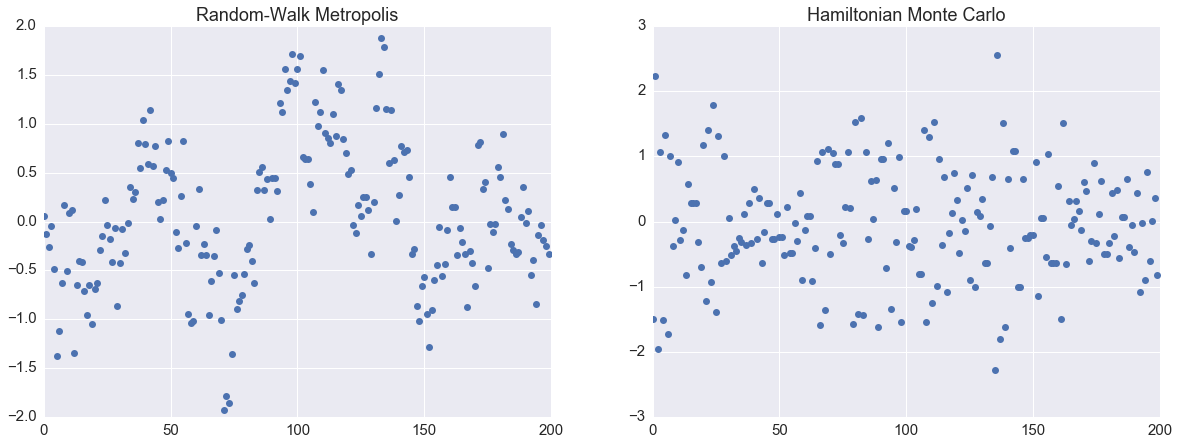

In [44]:
plt.figure(figsize=(20,7))

#Metropolis itertions - note the autocorrelation, even with thinning
#This is a consequence of the high correlation between variables
plt.subplot(121)
plt.plot(range(len(hmc_output_2d[:,0])),mh_output_2d[:,0], 'o')
plt.title('Random-Walk Metropolis')

#HMC iterations - much less autocorrelation, explores the space well
plt.subplot(122)
plt.title('Hamiltonian Monte Carlo')
plt.plot(range(len(hmc_output_2d[:,0])), hmc_output_2d[:,0], 'o')

plt.savefig("MH_HMC_single_position.png")

# MH vs MHC in High Dimension

**MH**

In [45]:
#Multivariate Normal target distribution parameters
mu_100 = np.zeros(100)
cov_100 = np.diag([(i/100)**2 for i in range(1,101)])

#Metropolis proposal parameters
mu_prop100 = np.zeros(100)
cov_prop100 = np.diag(np.repeat(stats.uniform.rvs(0.0176,0.0264)**2,100)) #Standard dev. as suggested by Neal
target_100d = stats.multivariate_normal(mu_100,cov_100)
proposal_100d = stats.multivariate_normal(mu_prop100,cov_prop100)

In [48]:
#Running Metropolis, keeping the mean and standard deviation of each variable
mh_output_100d, mh_ratio_100d = metropolis_multigaus(target_100d,proposal_100d,thin = 150,niters = 1000,dim = 100)
mh_means = mh_output_100d.mean(0)
mh_sds = mh_output_100d.std(0)

**HMC**

In [50]:
#Running HMC - note random stepsize in the high-dimensional setting
current_q = np.random.random(100)
hmc_output_100d = HMC(U, grad_U, current_q, Sigma = cov_100, stepsize=0.013, steps=150, max_iter= 1000,step_range = 0.2*0.013)
hmc_means = np.mean(hmc_output_100d,axis=0)
hmc_sds = np.std(hmc_output_100d,axis=0)


**Plotting**

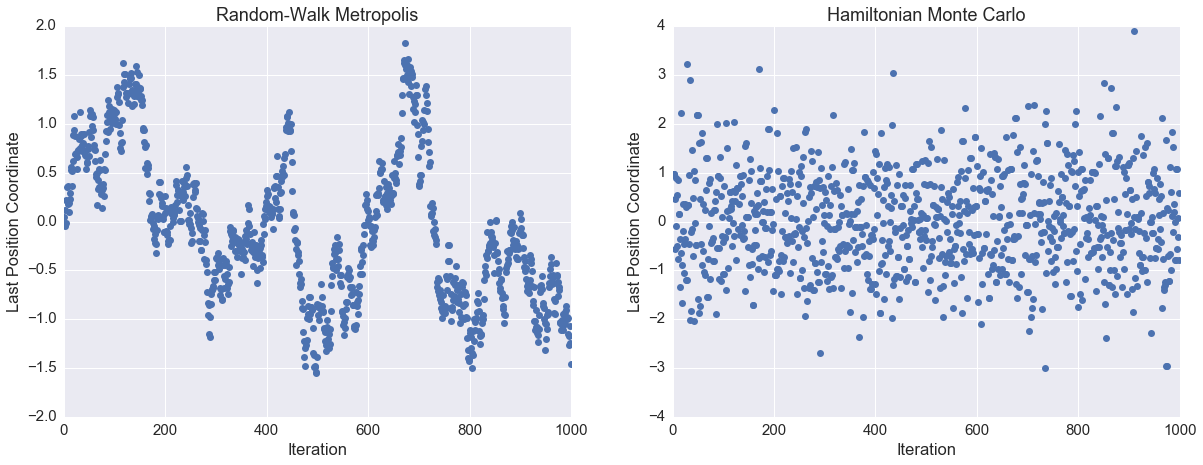

In [51]:
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis - note the high autocorrelation even with 150 thinning steps
#Small stepsize required because dimension is so high
ax[0].plot(range(1000),mh_output_100d[:,99],'o')
ax[0].set_title('Random-Walk Metropolis')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Last Position Coordinate")

#HMC - Covers the space very well, with apparently independent draws
ax[1].plot(range(1000),hmc_output_100d[:,99],'o')
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Last Position Coordinate")
plt.savefig("100d_iterations.png")

**Plotting all means and standard deviations**

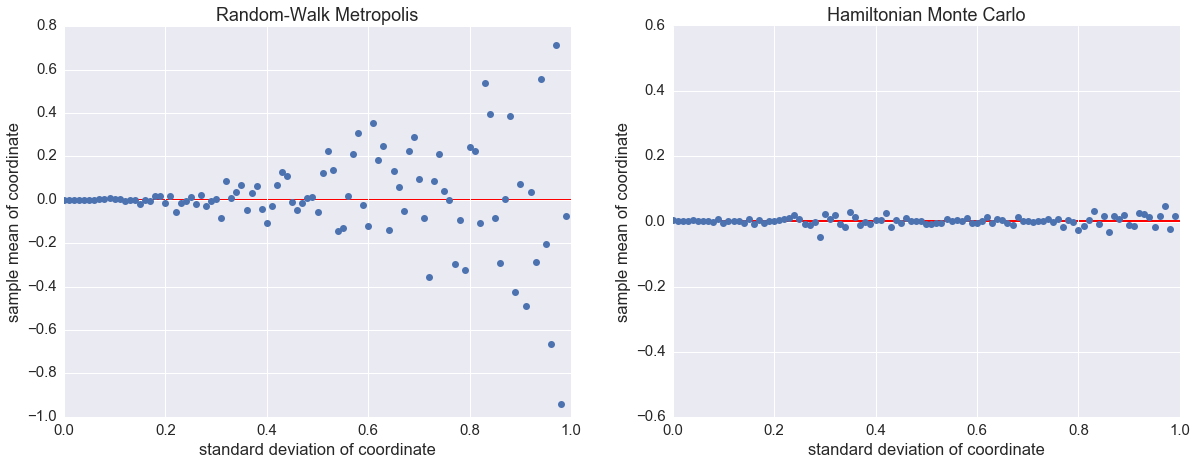

In [52]:
#All the means should be zero
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis means - unstable in higher dimensions
ax[0].plot([i/100 for i in range(len(mh_means))],mh_means,'o')
ax[0].set_title('Random-Walk Metropolis')
ax[0].set_xlabel("standard deviation of coordinate")
ax[0].set_ylabel("sample mean of coordinate")
ax[0].axhline(y=0.001,xmin=0,xmax=100,c="red",linewidth=2,zorder=0)

#HMC means stay close to zero for all variables
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].plot([i/100 for i in range(len(hmc_means))],hmc_means,'o')
ax[1].axhline(y=0.001,xmin=0,xmax=100,c="red",linewidth=2,zorder=0)
ax[1].set_xlabel("standard deviation of coordinate")
ax[1].set_ylabel("sample mean of coordinate")
ax[1].set_ylim((-.6,.6))

plt.savefig("100d_means.png")

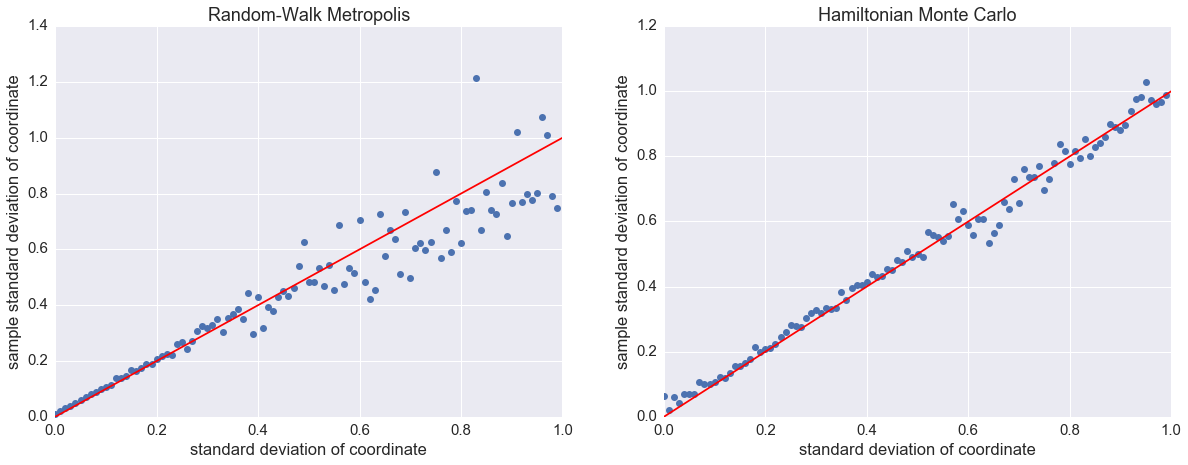

In [53]:
#Standard deviations should lie on the line y = x
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis standard deviations do not follow expected value in higher dimensions
ax[0].set_title('Random-Walk Metropolis')
ax[0].plot([i/100 for i in range(len(mh_sds))],mh_sds,'o')
ax[0].plot([0,1],[0,1],'r-')
ax[0].set_xlabel("standard deviation of coordinate")
ax[0].set_ylabel("sample standard deviation of coordinate")

#HMC output standard deviations follow the line more closely in higher dimensions
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].plot([i/100 for i in range(len(hmc_sds))],hmc_sds,'o')
ax[1].plot([0,1],[0,1],'r-')
ax[1].set_xlabel("standard deviation of coordinate")
ax[1].set_ylabel("sample standard deviation of coordinate")

plt.savefig("100d_sds.png")